## Assignment 1

Two datasets are given  
1. `HovsoreData_Sonic_100m_2004-2013.csv`  
contains about 10 years of simultaneous wind
speed and turbulence measurements.  

2. `ML_ExampleDataSet.xlsx`  
contains data of simulated 10-minute realizations of damageequivalent loads (DEL) for the DTU 10MW reference wind turbine as function of various external
conditions, including wind speed, turbulence, wind shear.

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn

### Loading the first dataset
Note that there are some extreme wind speeds in the dataset, which are likely to be errors so they are removed using `pipe_wsp`

In [199]:
data1 = pd.read_csv('../Datasets/HovsoreData_Sonic_100m_2004-2013.csv')

def pipe_wsp(df, wsp):
    return df[df['Wsp'] <= wsp]

wsp_lim = 50  # Limit for wind speed

# Chain operations
data1 = (
    data1
    # Filter out rows where Wsp is greater than wsp_lim
    .pipe(pipe_wsp, wsp=wsp_lim)
    # Set timestamp based on the Timestamp-column with the format 'YYYYMMDDHHMM'
    .assign(Timestamp=pd.to_datetime(data1['Timestamp'], format=r'%Y%m%d%H%M'))
)
data1

,Timestamp,Wsp,TI,"TI,detrend",MeanDir,MeanTrigDir,StdDir,MinDir,MaxDir
0,2004-10-01 00:00:00,9.9196,0.0181,0.0145,346.7130,346.7130,0.8440,343.893,349.044
1,2004-10-01 00:20:00,9.5073,0.0145,0.0116,346.9852,346.9852,0.6518,344.751,348.949
2,2004-10-01 00:30:00,9.5274,0.0210,0.0195,346.9152,346.9151,0.7949,343.754,350.588
3,2004-10-01 00:40:00,9.9498,0.0253,0.0195,346.3204,346.3204,0.7549,343.971,349.953
4,2004-10-01 00:50:00,10.2376,0.0151,0.0134,345.4185,345.4185,0.6362,343.074,348.960
...,...,...,...,...,...,...,...,...,...
439507,2013-08-31 23:10:00,15.6264,0.0773,0.0589,299.8040,299.8043,2.6738,288.901,309.955
439508,2013-08-31 23:20:00,13.7150,0.0576,0.0576,298.0319,298.0315,3.2644,288.643,309.245
439509,2013-08-31 23:30:00,13.4969,0.0797,0.0654,297.7226,297.7242,3.5721,284.827,306.117
439510,2013-08-31 23:40:00,13.4135,0.1034,0.0901,294.6266,294.6243,3.9459,283.195,310.353


### Question 2
Determine the probability distribution of the wind climate uncertainty variable $X_W$ by analysing the
wind data through bootstrapping, further incorporating a 1% uncertainty for windspeed

,Wsp
Timestamp,
2004,10.095511
2005,8.780938
2006,8.387078
2007,8.963619
2008,9.120064
2009,8.486631
2010,7.870342
2011,9.337742
2012,9.093408


<Axes: title={'center': 'Yearly mean wind speed'}, xlabel='Year', ylabel='Wind speed (m/s)'>

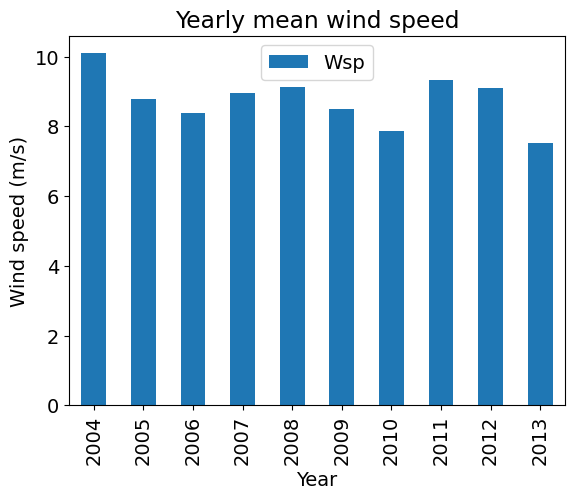

In [200]:
# Wind speed yearly means
wsp_yr_mean_df = pd.DataFrame(data1.groupby(data1['Timestamp'].dt.year)['Wsp'].mean())
display(wsp_yr_mean_df)

wsp_yr_mean_df.plot(kind='bar', title='Yearly mean wind speed', ylabel='Wind speed (m/s)', xlabel='Year')

In [201]:
wsp_yr_mean_arr = wsp_yr_mean_df.values.flatten()
wsp_yr_mean_arr

array([10.09551085,  8.7809385 ,  8.38707826,  8.96361853,  9.12006362,
        8.48663061,  7.87034221,  9.3377421 ,  9.09340775,  7.51549011])

In [202]:
Nbootstrap = 99999
BootstrapSize = len(wsp_yr_mean_arr)

# Rows are the indices of the samples, columns are the bootstrap samples
Bsample = np.random.randint(low=0, high=BootstrapSize, size=(Nbootstrap, BootstrapSize))

BootstrapSample = np.zeros((Nbootstrap, BootstrapSize))
for i in range(Nbootstrap):
    for j in range(BootstrapSize):
        BootstrapSample[i, j] = wsp_yr_mean_arr[Bsample[i, j]]

BootstrapSample = np.mean(BootstrapSample, axis=1)

# Sort the bootstrap means (only relevant for the confidence interval)
BootstrapMeans = np.sort(BootstrapSample)

In [203]:
Ubins = np.linspace(BootstrapMeans.min(), BootstrapMeans.max(), 100)

BootstrapHist = np.histogram(BootstrapMeans, bins=Ubins)
BootstrapDist = stats.rv_histogram(BootstrapHist)
pdf_B = BootstrapDist.pdf(Ubins)

Umean = np.mean(wsp_yr_mean_arr)
Ustd = np.std(wsp_yr_mean_arr)
n = len(wsp_yr_mean_arr)

pdf_N = stats.norm.pdf(Ubins, Umean, Ustd/np.sqrt(n))

In [204]:
alpha = 0.05
# -1 because of Python indexing, +1 because of the formula
Rlow = int((Nbootstrap+1)*alpha/2) - 1
Rhigh = int((Nbootstrap+1)*(1-alpha/2)) - 1

CIn_B_orig = BootstrapMeans[Rlow]
CIp_B_orig = BootstrapMeans[Rhigh]

print(
    'Confidence interval based on bootstrapping: [' + str(CIn_B_orig) + ', ' + str(CIp_B_orig) + ']')

# Scaling the uncertainty with 1% for the wind speed measurements
# and 1% for the joint probability distribution

CIn_B = CIn_B_orig * 0.99
CIp_B = CIp_B_orig * 1.01

print('Confidence interval based on bootstrapping with 2% uncertainty: [' + str(
    CIn_B) + ', ' + str(CIp_B) + ']')

Confidence interval based on bootstrapping: [8.326427678651994, 9.197096429328324]
Confidence interval based on bootstrapping with 2% uncertainty: [8.243163401865473, 9.289067393621607]


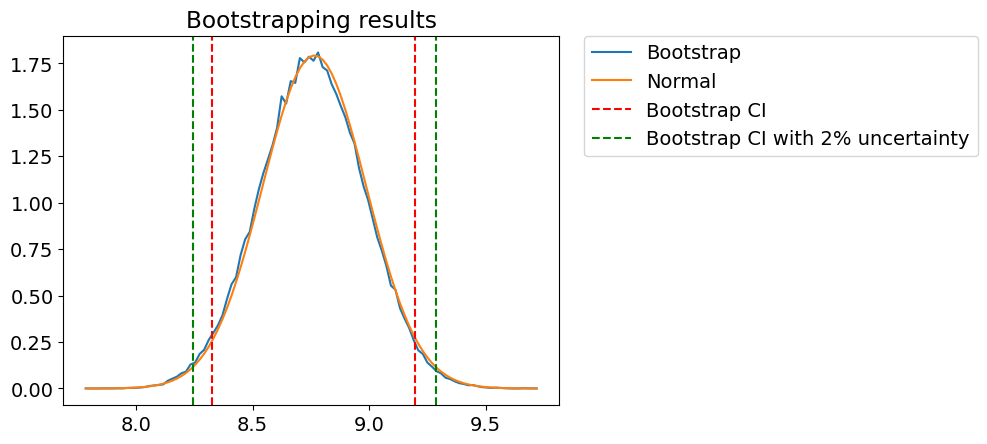

In [205]:
plt.figure()
plt.title('Bootstrapping results')
# plt.hist(BootstrapMeans, bins=Ubins, density=True, alpha=0.5, label='Bootstrap')
plt.plot(Ubins, pdf_B, label='Bootstrap')
plt.plot(Ubins, pdf_N, label='Normal')
plt.axvline(CIn_B_orig, color='r', linestyle='--', label='Bootstrap CI')
plt.axvline(CIp_B_orig, color='r', linestyle='--')
plt.axvline(CIn_B, color='g', linestyle='--', label='Bootstrap CI with 2% uncertainty')
plt.axvline(CIp_B, color='g', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

### Loading the second dataset

In [206]:
InputData = pd.read_excel('../Datasets/ML_ExampleDataSet.xlsx', 'InputVariables')
InputData = InputData.set_index('Sample_No', drop=False)
InputData

,Sample_No,U,SigmaU,Alpha,MannL,MannGamma,VeerDeltaPhi
Sample_No,,,,,,,
1,1,4.000000,0.100000,-0.650000,7.500000,1.000000,-22.250000
2,2,10.150758,1.208656,-0.139692,48.470634,1.363636,-4.771217
3,3,6.813467,2.261463,0.129071,88.379710,1.727273,-3.981593
4,4,14.500000,0.704260,0.332996,122.142857,2.090909,0.162810
5,5,5.356299,1.776301,1.147039,160.357143,2.454545,2.639008
...,...,...,...,...,...,...,...
9996,9996,15.991490,2.934493,-0.031461,271.543107,3.760740,14.080259
9997,9997,6.111425,0.948102,0.176589,8.454959,4.124377,41.866315
9998,9998,13.326172,2.043617,0.345013,46.669245,4.488013,-6.197441


In [207]:
TargetData = pd.read_excel('../Datasets/ML_ExampleDataSet.xlsx', 'LoadResults')
TargetData.set_index('PointNo', drop=False, inplace=True)
TargetData

,PointNo,Tower_top_fore_aft_M_x,Tower_top_side2side_M_y,Tower_base_fore_aft_M_x,Tower_base_side2side_M_y,Yaw_moment_M_z,Main_shaft_torsion_M_z,Blade_root_flapwise_M_x,Blade_root_edgewise_M_y
PointNo,,,,,,,,,
1,1,747.561872,200.666288,6708.717789,8861.885588,1229.076579,63.457528,4253.317748,15006.726860
2,2,3556.031457,676.339081,16692.647572,6329.099515,6952.985180,1354.995442,10409.290476,16289.414152
3,3,4667.540374,1337.390736,47357.937376,31829.036012,10138.140146,2804.304402,13755.148891,16535.154243
4,4,2468.757942,242.431345,8130.594535,3871.907737,4216.051060,250.684887,12307.312889,16500.098901
5,5,3261.845253,1035.420007,36971.924749,26395.063750,6630.640795,2256.349794,13128.763279,16207.306417
...,...,...,...,...,...,...,...,...,...
9996,9996,6564.464434,858.778565,28091.651088,13608.101268,14513.682848,1147.107370,21518.552601,16773.394758
9997,9997,2047.344061,385.287048,22144.619831,16663.888804,3024.747490,676.705869,3891.227781,15376.750042
9998,9998,5958.074303,646.040924,20715.173212,7395.479028,11789.005321,740.922800,19334.780023,17384.510924


### Question 3
Set up a load surrogate model $M_x$ that maps the 10-minute DELs as function of $u$, $\sigma_{u}$ and $\alpha$

In [208]:
AllInputData = InputData.where(InputData['Sample_No'] == TargetData['PointNo'])
AllInputData.drop(columns='Sample_No', inplace=True)
ANNInputData = AllInputData[['U', 'SigmaU', 'Alpha']]
ANNInputData

,U,SigmaU,Alpha
Sample_No,,,
1,4.000000,0.100000,-0.650000
2,10.150758,1.208656,-0.139692
3,6.813467,2.261463,0.129071
4,14.500000,0.704260,0.332996
5,5.356299,1.776301,1.147039
...,...,...,...
9996,15.991490,2.934493,-0.031461
9997,6.111425,0.948102,0.176589
9998,13.326172,2.043617,0.345013


In [209]:
AllTargetData = TargetData.where(TargetData['PointNo'] == InputData['Sample_No'])
AllTargetData.drop(columns='PointNo', inplace=True)
AllTargetData

,Tower_top_fore_aft_M_x,Tower_top_side2side_M_y,Tower_base_fore_aft_M_x,Tower_base_side2side_M_y,Yaw_moment_M_z,Main_shaft_torsion_M_z,Blade_root_flapwise_M_x,Blade_root_edgewise_M_y
PointNo,,,,,,,,
1,747.561872,200.666288,6708.717789,8861.885588,1229.076579,63.457528,4253.317748,15006.726860
2,3556.031457,676.339081,16692.647572,6329.099515,6952.985180,1354.995442,10409.290476,16289.414152
3,4667.540374,1337.390736,47357.937376,31829.036012,10138.140146,2804.304402,13755.148891,16535.154243
4,2468.757942,242.431345,8130.594535,3871.907737,4216.051060,250.684887,12307.312889,16500.098901
5,3261.845253,1035.420007,36971.924749,26395.063750,6630.640795,2256.349794,13128.763279,16207.306417
...,...,...,...,...,...,...,...,...
9996,6564.464434,858.778565,28091.651088,13608.101268,14513.682848,1147.107370,21518.552601,16773.394758
9997,2047.344061,385.287048,22144.619831,16663.888804,3024.747490,676.705869,3891.227781,15376.750042
9998,5958.074303,646.040924,20715.173212,7395.479028,11789.005321,740.922800,19334.780023,17384.510924


In [210]:
nsamples = ANNInputData['U'].count()
print('Number of samples:', nsamples)

Number of samples: 9980


In [211]:
Y1 = AllTargetData['Blade_root_flapwise_M_x']
X = ANNInputData.values

In [212]:
Xscaler = sklearn.preprocessing.StandardScaler()
Yscaler = sklearn.preprocessing.StandardScaler()
Xscaler = Xscaler.fit(ANNInputData)
Yscaler = Yscaler.fit(Y1.values.reshape(-1, 1))


train_test_ratio = 0.8
ntrain = int(train_test_ratio * nsamples)

Xtrain = Xscaler.transform(ANNInputData.iloc[0:ntrain, :])
Xtest = Xscaler.transform(ANNInputData.iloc[ntrain:, :])
Ytrain = Yscaler.transform(Y1.values[0:ntrain].reshape(-1, 1))
Ytest = Yscaler.transform(Y1.values[ntrain:].reshape(-1, 1))

In [213]:
ANNmodel = sklearn.neural_network.MLPRegressor(
    hidden_layer_sizes=(12, 12),
    activation='relu',
    max_iter=1000,
)
ANNmodel.fit(Xtrain, Ytrain)
print('Train set r-square: ' + str(ANNmodel.score(Xtrain, Ytrain)))
print('Test set r-square: ' + str(ANNmodel.score(Xtest, Ytest)))

c:\Users\Toke Schäffer\Documents\Egne mapper\DTU\Kandidat\3. semester vind\46500 Probabilistic Methods in Wind Energy\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train set r-square: 0.967363517596014
Test set r-square: 0.9675752996325749


In [214]:
Yout = Yscaler.inverse_transform(ANNmodel.predict(Xtest).reshape(-1, 1))
Yout_test = Yscaler.inverse_transform(ANNmodel.predict(Xtest).reshape(-1, 1))

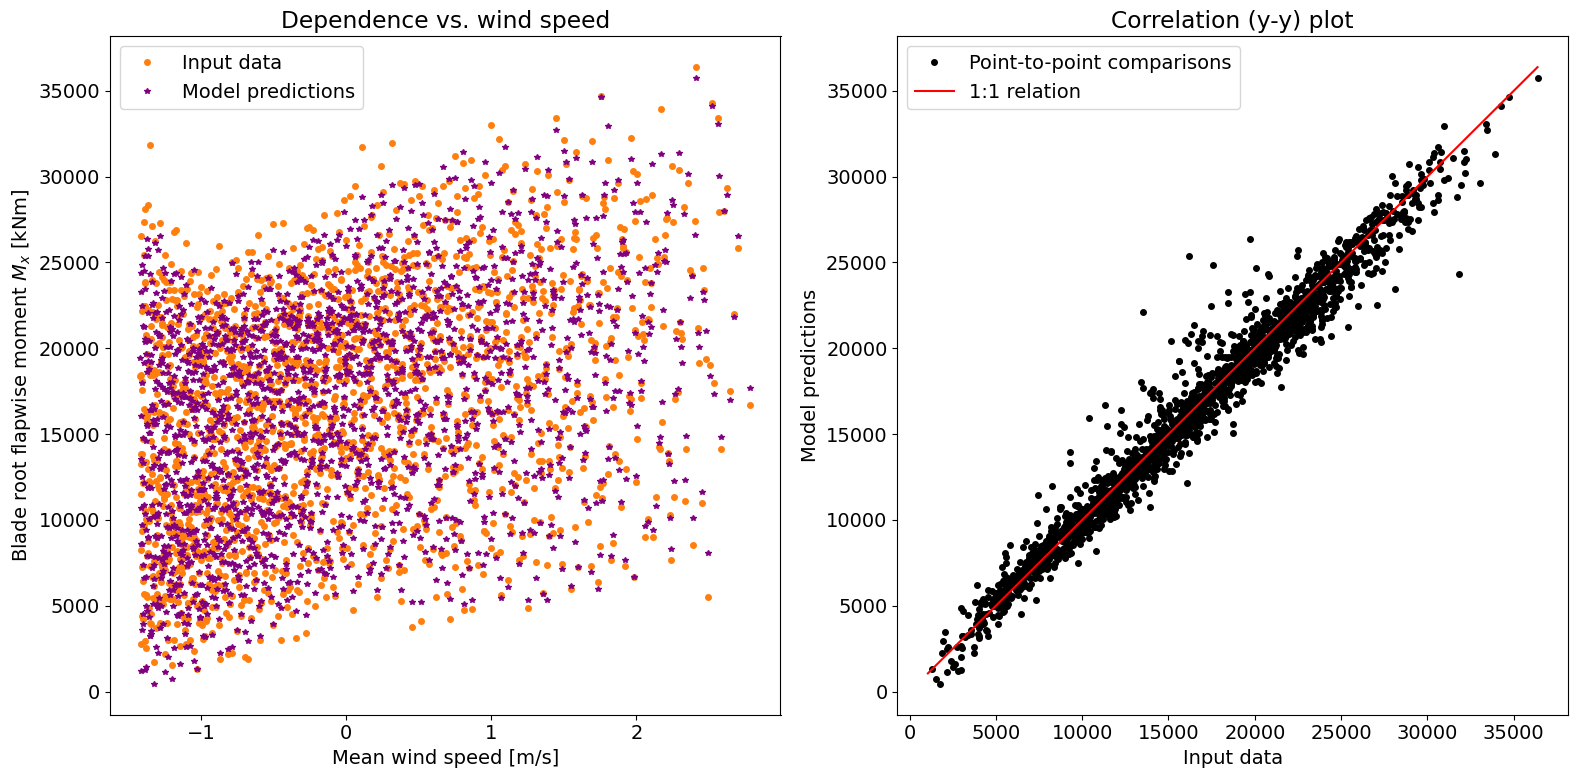

In [215]:
plt.rc('font', size=14)
fig3, axs3 = plt.subplots(1, 2, figsize=(16, 8))

plt.setp(axs3[0],
         title='Dependence vs. wind speed',
         xlabel='Mean wind speed [m/s]',
         ylabel='Blade root flapwise moment $M_x$ [kNm]')

plt.setp(axs3[1],
         title='Correlation (y-y) plot',
         xlabel='Input data',
         ylabel='Model predictions')

axs3[0].plot(Xtest[:, 0],
             Yscaler.inverse_transform(Ytest),
             'o', markersize=4, color='C1')

axs3[0].plot(Xtest[:, 0], Yout_test, '*', markersize=4, color='purple')

axs3[0].legend(['Input data', 'Model predictions'])

axs3[1].plot(Yscaler.inverse_transform(Ytest), Yout_test, 'ok', markersize=4)

axs3[1].plot(np.array([np.min(Y1), np.max(Y1)]),
             np.array([np.min(Y1), np.max(Y1)]), '-r')

axs3[1].legend(['Point-to-point comparisons', '1:1 relation'])
plt.tight_layout()
plt.show()